In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
def load_file(input_file):
    with open(input_file, 'r') as f:
        lines = f.read().strip().split('\n')
        var_order = 'EDWdgvtac'
        params = {}
        for i in range(6):
            params[var_order[i]] = [int(n) for n in lines[i].split()[1:]]
        idx = 6
        for i in range(3):
            n_rows = len(params[var_order[i]])
            params[lines[idx]] = np.array(
                            [line.split() for line in \
                            lines[idx+1 : idx+1+n_rows]],
                            dtype=float)
            idx += 1 + n_rows
    return [params[var] for var in var_order]

In [27]:
E, D, W, d, g, v, t, a, c = load_file('data/costa.txt')

In [32]:
['E'] + list(np.random.randint(300, 400, 4, ))

['E', 336, 317, 331, 376]

In [34]:
np.random.randint(300, 500, 4) // 10

array([40, 34, 38, 45])

In [4]:
def generate_file(output_file, 
                  n_S, S_cap, n_P, P_cap, 
                  n_D, D_cap, n_C, C_dem, 
                  P_cost, D_cost, 
                  SP_cost, PD_cost, DC_cost, random_state=None):
    if random_state:
        np.random.seed(random_state)
    with open(output_file, 'w') as f:
        var_order = 'EDWdgvtac'
        vals_order = [(n_S, S_cap), (n_P, P_cap), (n_D, D_cap), 
                      (n_C, C_dem), (n_P, P_cost), (n_D, D_cost),
                      SP_cost, PD_cost, DC_cost]
        for i in range(6):
            print(' '.join([var_order[i]] + [str(n) for n in \
                10 * np.random.randint(vals_order[i][1][0]//10, 
                                       vals_order[i][1][1]//10, 
                                       vals_order[i][0])]), file=f)
        for i in range(3):
            print(var_order[6+i], file=f)
            for j in range(vals_order[i][0]):
                print(' '.join([str(n) for n in \
                        np.random.randint(vals_order[6+i][0],
                                          vals_order[6+i][1],
                                          vals_order[i+1][0])]), file=f)        

In [5]:
generate_file('data/output2.txt',
                 5, (600, 2000), 10, (500, 1000),
                 10, (300, 800), 30, (100, 500),
                 (1000, 1500), (1000, 1500),
                 (1, 10), (1, 10), (1, 10), random_state=42
             )

In [69]:
import re
def generate_ampl(data_file, output_file, ampl_model='modelos/priority_encoding.mod'):
    with open(ampl_model, 'r') as f_model, \
         open(output_file, 'w') as f_output:
        lines = f_model.read().strip().split('\n')
        idx = [i for i, val in enumerate(lines) if 'data;' in val][0]
        for line in lines[:idx+2]:
            print(line, file=f_output)
        E, D, W, d, g, v, t, a, c = load_file(data_file)
        values = [E, D, W, d, g, v, t, a, c]
        sets = 'SKJI'
        params = 'EDWd'
        for i in range(4):
            elements = [f'{sets[i]}{j+1}' for j in range(len(values[i]))]
            print(f'set {sets[i]} := {" ".join(elements)};', file=f_output)
        print(file=f_output)
        
        for i in range(4):
            elements = [f'{sets[i]}{j+1} {values[i][j]}' for j in range(len(values[i]))]
            print(f'param {params[i]} := {" ".join(elements)};', file=f_output)
        print(file=f_output)
        
        params = 'gv'
        for i in range(2):
            elements = [f'{sets[i+1]}{j+1} {values[i+4][j]}' for j in range(len(values[i+1]))]
            print(f'param {params[i]} := {" ".join(elements)};', file=f_output)
        print(file=f_output)
        
        params = 'tac'
        for i in range(3):
            elements = [f'{sets[i+1]}{j+1}' for j in range(len(values[i+1]))]
            print(f'param {params[i]}: {" ".join(elements)} :=', file=f_output)
            for j in range(len(values[i])):
                elements = [str(n) for n in values[i+6][j]]
                print(f'      {sets[i]}{j+1} {" ".join(elements)}', file=f_output)
            print(';\n', file=f_output)
        
        idx = [i for i, val in enumerate(lines) if 'P_max :=' in val][0]
        for line in lines[idx:]:
            line = re.sub('P_max := \d', f'P_max := {len(D)}', line)
            line = re.sub('W_max := \d', f'W_max := {len(W)}', line)
            print(line, file=f_output)

In [70]:
generate_ampl('data/costa.txt', 'data/ampl.txt')

In [71]:
generate_ampl('data/output2.txt', 'data/output2_ampl.txt')

In [6]:
E, D, W, d, g, v, t, a, c = load_file('data/output2.txt')

In [34]:
from utils import chromosome_fitness
from utils import init_genetic_algorithm
from deap import tools, algorithms

toolbox, stats = init_genetic_algorithm(chromosome_fitness,
                            E, D, W, d, g, v, t, a, c)
pop = toolbox.population(n=100)
hof = tools.HallOfFame(5)

In [35]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2,
                              ngen=30, stats=stats, halloffame=hof,
                              verbose=True)

gen	nevals	Avg    	Std    	Min  	Max  
0  	100   	50185.4	3338.68	40270	59310
1  	61    	48009.2	3314.76	40270	56770
2  	55    	46993.8	3255.06	40270	58340
3  	62    	45476.4	2901.25	40000	55540
4  	61    	45041.6	3164.01	40000	54540
5  	63    	44692  	3356.41	39810	57010
6  	64    	43872.6	2910.87	40000	56310
7  	71    	43216  	2784.75	38380	56110
8  	74    	43578.2	3500.7 	38380	55950
9  	60    	42719.4	2972.12	38380	53510
10 	61    	42452.8	3128.83	37230	52670
11 	67    	43064.9	3275.09	37230	51310
12 	68    	42941.1	3487.19	37230	52760
13 	58    	42373.8	3667.85	37140	57120
14 	48    	41469.9	3455.31	37140	52220
15 	69    	42064.8	3647.94	37140	51860
16 	64    	41201.1	3293.49	37140	53790
17 	58    	40978.2	3242.26	37140	52700
18 	44    	39736.3	3093.4 	37140	51380
19 	64    	39454.7	3752.15	37140	53010
20 	65    	38619.4	2844.67	37140	50660
21 	66    	38000.3	2034.63	37140	48080
22 	53    	38194.3	2532.77	37140	47950
23 	66    	37954.9	2150.66	37140	48680
24 	51    	38326.9	2800.2

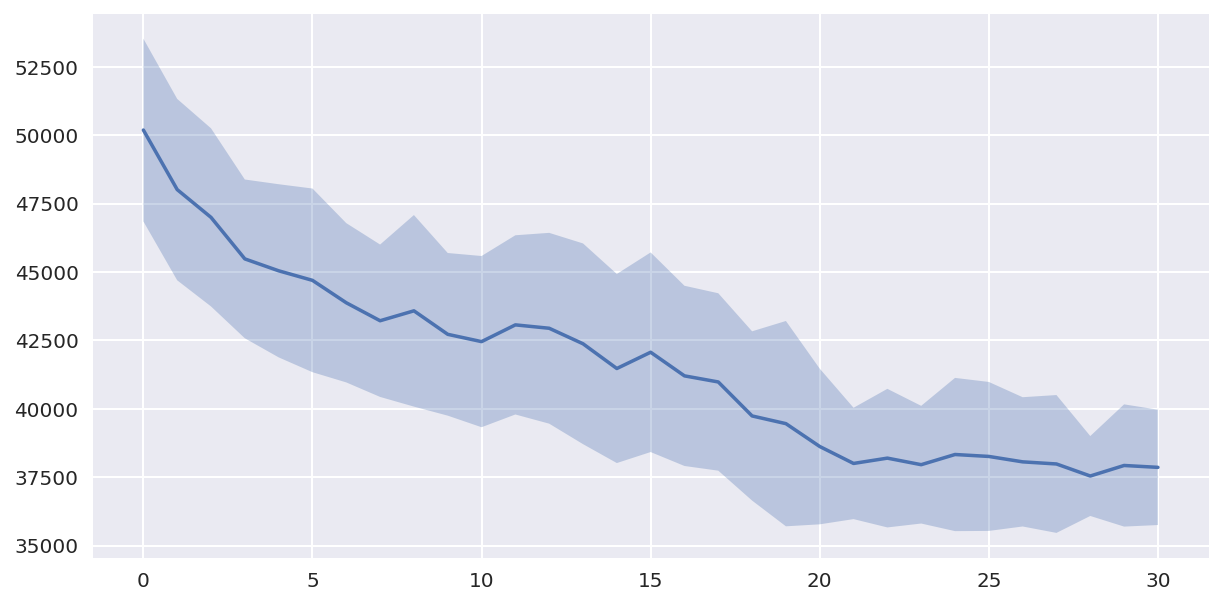

In [36]:
from utils import plot_log
plot_log(log)

In [37]:
chromosome_fitness(hof.items[0], E, D, W, d, t, a, c, g, v)

37140.0

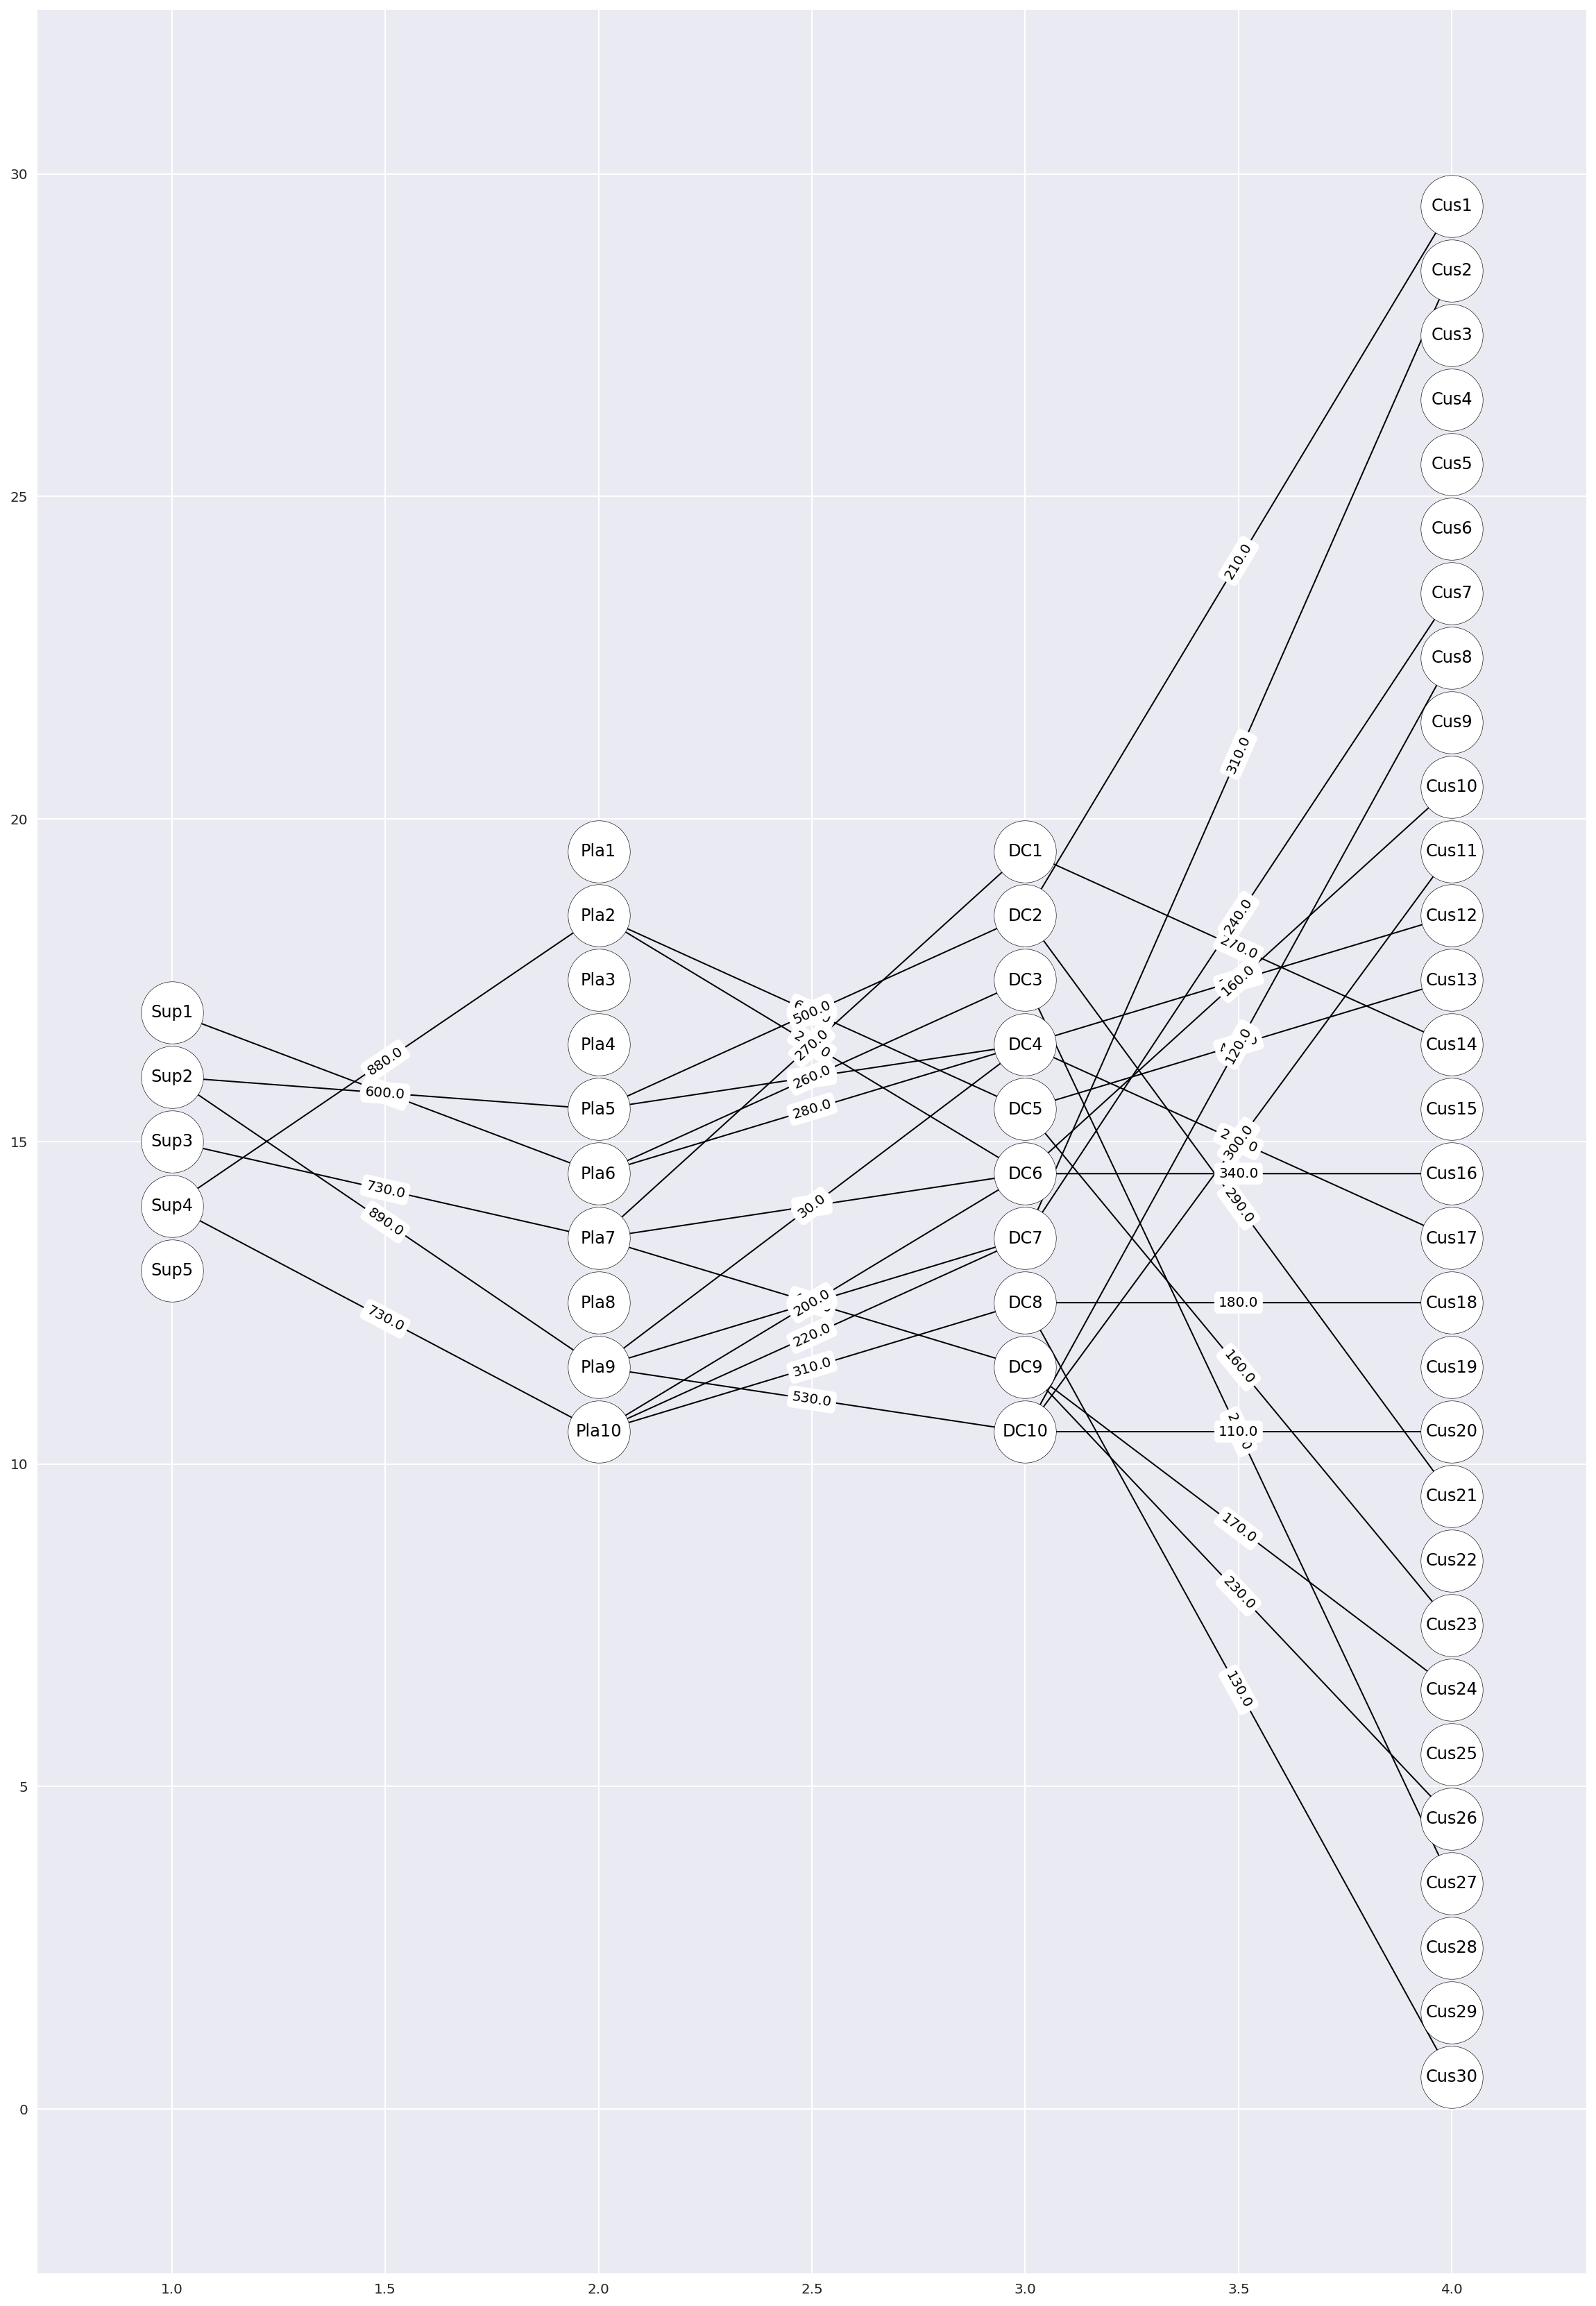

In [45]:
from utils import decode_chromosome, plot_graph
q, z, f, p, b, s = decode_chromosome(hof.items[0], E, D, W, d, t, a, c)
plot_graph(b, f, q, figsize=(20,30))